In [ ]:
# Last amended: 24th September, 2021
# My folder: lubuntu_spark: /home/ashok/Documents/spark/2.ml/1.demo
# Data Source: http://insideairbnb.com/get-the-data.html
# Ref:
# https://www.linkedin.com/pulse/building-scalable-machine-learning-pipelines-apache-spark-rajat-gupta
# Pipelines:
# https://spark.apache.org/docs/latest/ml-pipeline.html

# Using simple Pipeline

## A. Call libraries

In [4]:
# 1.0 
import numpy as np
import pandas as pd

In [5]:
# 1.1 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [6]:
# 1.2 
from pyspark.ml.pipeline import Pipeline

In [7]:
# 1.3 Transfer files to hadoop:



! hdfs dfs -rm -r -f /user/ashok/data_files/boston
! hdfs dfs -mkdir -p /user/ashok/data_files/boston
! hdfs dfs -put /cdata/misc_datasets/boston_housing/boston_housing.csv.gz  /user/ashok/data_files/boston
! hdfs dfs -ls /user/ashok/data_files/boston



Deleted /user/ashok/data_files/boston
2021-09-24 16:23:19,232 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
Found 1 items
-rw-r--r--   1 ashok supergroup      11832 2021-09-24 16:23 /user/ashok/data_files/boston/boston_housing.csv.gz


In [8]:
# 1.4 Display multiple command outputs from a cell  

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## B. Read data

In [9]:
# 2.0 Read Data
#     We are only specifying the folder. Not the filename.

df = spark.read.csv(
                    path = "hdfs://localhost:9000/user/ashok/data_files/boston",
                    inferSchema = True,
                    header = True
                   )


In [10]:
# 2.1 A bit about data:

df.columns
df.count()

['crimerate',
 'zone',
 'non_retailbusiness',
 'river',
 'pollution',
 'avgrooms',
 'age',
 'wt_distances',
 'highwayaccess',
 'taxrate',
 'pupil_teacherratio',
 'caste_composition',
 'lowerstatus_pop',
 'median_value']

506

In [11]:
# 2.2 

df.select(df.columns[:10]).show(3)
df.select(df.columns[10:]).show(3)

+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
|crimerate|zone|non_retailbusiness|river|pollution|avgrooms| age|wt_distances|highwayaccess|taxrate|
+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
|  0.00632|18.0|              2.31|    0|    0.538|   6.575|65.2|        4.09|            1|    296|
|  0.02731| 0.0|              7.07|    0|    0.469|   6.421|78.9|      4.9671|            2|    242|
|  0.02729| 0.0|              7.07|    0|    0.469|   7.185|61.1|      4.9671|            2|    242|
+---------+----+------------------+-----+---------+--------+----+------------+-------------+-------+
only showing top 3 rows

+------------------+-----------------+---------------+------------+
|pupil_teacherratio|caste_composition|lowerstatus_pop|median_value|
+------------------+-----------------+---------------+------------+
|              15.3|            396.9|           4.98|        24

## C. Machine Learning

### Rename target
In ml algorthms, default name for target column is 'label'

In [12]:
# 2.3

df = df.withColumnRenamed('median_value', 'label')


### Partition

In [66]:
# 3.0
# 80:20 split

train, test = df.randomSplit([0.8,0.2])

In [67]:
# 3.1

train.count()
test.count()

409

97

## D. Create pipeline for modeling

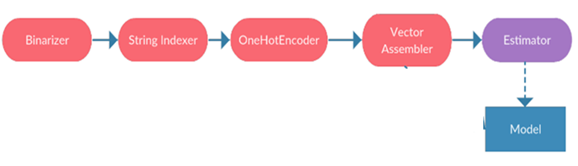

In [68]:
cols = train.columns[:-1]
cols

['crimerate',
 'zone',
 'non_retailbusiness',
 'river',
 'pollution',
 'avgrooms',
 'age',
 'wt_distances',
 'highwayaccess',
 'taxrate',
 'pupil_teacherratio',
 'caste_composition',
 'lowerstatus_pop']

In [69]:
# 4.0
pipe = Pipeline (
                 stages = [
                           VectorAssembler(
                                           inputCols = cols,
                                           outputCol = 'features'
                                          ),
 
                     
                           RandomForestRegressor()
                          ]
                )

## Train pipe
And make predcitions

In [70]:
# 4.1 Fit the pipe and create model:

model = pipe.fit(train)

In [71]:
# 4.2 MAke predictions:

predicted = model.transform(test)

In [72]:
# 4.3 Look at the columns

predicted.columns


['crimerate',
 'zone',
 'non_retailbusiness',
 'river',
 'pollution',
 'avgrooms',
 'age',
 'wt_distances',
 'highwayaccess',
 'taxrate',
 'pupil_teacherratio',
 'caste_composition',
 'lowerstatus_pop',
 'label',
 'features',
 'prediction']

In [73]:
# 4.4 Look at the data

predicted.select(predicted.columns[:10]).show(3)
predicted.select(predicted.columns[10:]).show(3)

+---------+-----+------------------+-----+---------+--------+----+------------+-------------+-------+
|crimerate| zone|non_retailbusiness|river|pollution|avgrooms| age|wt_distances|highwayaccess|taxrate|
+---------+-----+------------------+-----+---------+--------+----+------------+-------------+-------+
|  0.01432|100.0|              1.32|    0|    0.411|   6.816|40.5|      8.3248|            5|    256|
|   0.0187| 85.0|              4.15|    0|    0.429|   6.516|27.7|      8.5353|            4|    351|
|  0.02543| 55.0|              3.78|    0|    0.484|   6.696|56.4|      5.7321|            5|    370|
+---------+-----+------------------+-----+---------+--------+----+------------+-------------+-------+
only showing top 3 rows

+------------------+-----------------+---------------+-----+--------------------+------------------+
|pupil_teacherratio|caste_composition|lowerstatus_pop|label|            features|        prediction|
+------------------+-----------------+---------------+-----

In [74]:
# 5.0 Evaluate performance:

evaluator = RegressionEvaluator(metricName = "rmse")
evaluator.evaluate(predicted)

3.59544167746105

## Pipeline with StandardScaler


[StandardScaler](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html#pyspark.ml.feature.StandardScaler)<br>
[PCA](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.PCA.html#pyspark.ml.feature.PCA)

In [75]:
# Call libraries
#from pyspark.ml.feature import PCA
#from pyspark.ml.feature import StandardScaler

In [76]:
# Create pipeline of all operations:

pipe = Pipeline (
                 stages = [
                          
                     
                     
                          ]
                )

In [77]:
# Fit train data and create model


In [78]:
# 4.2 MAke predictions:



In [79]:
# 5.0 Evaluate performance:



4.031717320847001

In [ ]:
############### I am done ###############